In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.versioned_prov
from tools.query.versioned_prov import *

In [2]:
def wdf_text(e2, e1, a, attrs):
    return querier.text("wasDerivedFrom", [e2, e1, a], attrs=dict(attrs), id_=None)

def get_original_reference(ref, result=None):
    A, D, AT, TX = var(4)
    if result is None:
        result = set()
    first = False
    while not first:
        first = True
        query = [
            (A.bound, D.bound, TX.bound, AT.bound) 
            for __ in (
                wasDerivedFrom(ref, D, A, type="version:Reference", attrs=AT)
                & entity(D, text=TX)
            )]
        if query:
            act, ent, text, attrs = query[0]
            result.add(text)
            result.add(wdf_text(ref, ent, act, attrs))
            first = False
            ref = ent
    return ref, result

In [3]:
from collections import namedtuple
from copy import copy
from pprint import pprint

Context = namedtuple("Context", "type checkpoint")


def neighborhood(context):
    n, time = context
    
    _ = BLANK
    A, C, D, T, TP, U, W, AT, TX, TX2, TX3 = var("A C D T TP U W AT TX TX2 TX3")
    
    # If time is not in the context, get it from the entity
    if not time:
        time = [T.bound for _ in entity(n, checkpoint=T)][0]

    # Follow default derivations
    query = (
        wasDerivedFrom(n, D, A, _, _, type=TP, checkpoint=T, whole=W, attrs=AT)
        & entity(D, _, TX)
    )
    for __ in query:
        result = {TX.bound, wdf_text(n, D.bound, A.bound, AT.bound)}
        if W.bound:
            for __ in entity(W, _, TX2):
                result.add(TX2.bound)
        yield Context(D.bound, None), result
        
                
    # Get initial reference to value
    original, result = get_original_reference(n)

    # Move to all parts of the structure 
    # Sort derivedByInsertion
    parts = [
        (T.bound, A.bound, D.bound, TP.bound, TX.bound)
        for __ in hadMember(n, D, type=TP, key=A, checkpoint=T, text=TX)
        if T.bound <= time
    ]
    parts.sort()
    # Reconstruct state
    state = {}
    for __, key, value, type_, text in parts:
        for __ in entity(value, _, TX):
            state[key] = (value, {text, TX.bound})
    # Move to parts of the state
    for value, text in state.values():
        yield (Context(value, time), result | text)
            

def dfs(ent, neigh):
    context = Context(ent, None)
    stack = [context]
    visited = set()
    TX = var("text")
    result = {TX.bound for __ in entity(ent, text=TX)} 
    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result

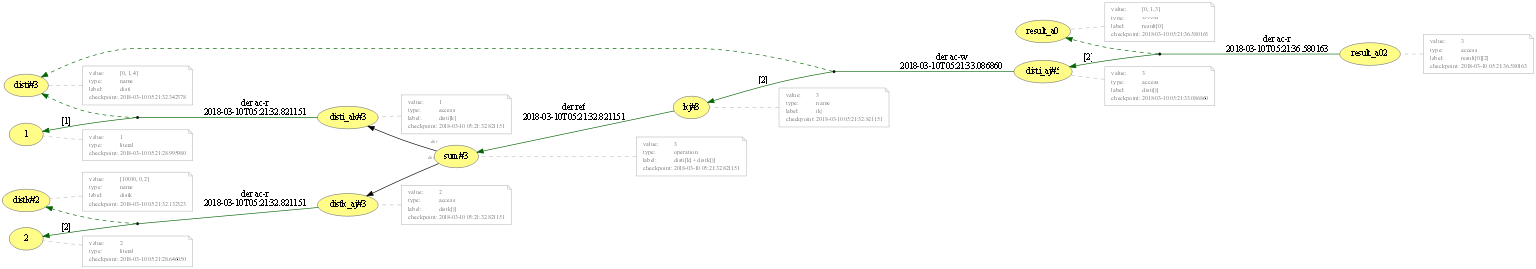

In [9]:
querier.load("../generated/versioned_prov/floydwarshall.provn");
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../generated/versioned_prov/query", view),
    '\n'.join(dfs("result_a02", neighborhood))
)

## Old query

Accesses go both to accessed element and to whole

In [5]:
from collections import namedtuple
from copy import copy
from pprint import pprint

Context = namedtuple("Context", "type to_parts checkpoint")


def neighborhood(context):
    n, move_to_parts, time = context
    
    _ = BLANK
    A, C, D, T, TP, U, W, AT, TX, TX2, TX3 = var("A C D T TP U W AT TX TX2 TX3")
    
    # If time is not in the context, get it from the entity
    if not time:
        time = [T.bound for _ in entity(n, T)][0]

    # Follow default derivations
    query = (
        wasDerivedFrom(n, D, A, _, _, type=TP, checkpoint=T, whole=W, attrs=AT)
        & entity(D, _, TX)
    )
    for __ in query:
        if TP.bound == "version:Reference":
            yield Context(D.bound, move_to_parts, None), {TX.bound, wdf_text(n, D.bound, A.bound, AT.bound)}
        else:
            yield Context(D.bound, True, None), {TX.bound, wdf_text(n, D.bound, A.bound, AT.bound)}
        # Move to whole
        if W.bound:
            for __ in entity(W.bound, _, TX2):
                yield Context(W.bound, False, T.bound), {wdf_text(n, D.bound, A.bound, AT.bound), TX2.bound}    
    
    if move_to_parts:
        # Get initial reference to value
        original, result = get_original_reference(n)

        # Move to all parts of the structure 
        # Sort derivedByInsertion
        parts = [
            (T.bound, A.bound, D.bound, TP.bound, TX.bound)
            for __ in hadMember(n, D, type=TP, key=A, checkpoint=T, text=TX)
            if T.bound <= time
        ]
        parts.sort()
        # Reconstruct state
        state = {}
        for __, key, value, type_, text in parts:
            for __ in entity(value, _, TX):
                state[key] = (value, {text, TX.bound})
        # Move to parts of the state
        for value, text in state.values():
            yield (Context(value, True, time), result | text)
            

def dfs(ent, neigh):
    context = Context(ent, True, None)
    stack = [context]
    visited = set()
    TX = var("text")
    result = {TX.bound for __ in entity(ent, text=TX)} 
    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result